## Test SPIM data CEBRA model

- Use CEBRA label contrastive learning on neural data from one fish
    - design model
    - convert SPIM data to usable format 
    - load data
    - fit with label
    - plot embeddings
    - try to predict stimulus presence
    - try to decode stimulus type (left/right spots)
        - create a discrete variable that labels the post-stimulus frames for right and left spots
        - This should inform the decoder to separate embedding states (which should vary between left and right spots)<br/><br/>

In [1]:
import cebra
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from sklearn.model_selection import train_test_split

In [2]:
### define globals ### 

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

global FILEPATH
global TIMESTEPS
global ROIS
global ITERS
global LOAD
global STIM_TYPES
global STIMS
global STIM_MASKS
global TRAINING_TEST_SPLIT

FILEPATH = dat_files[0]
TIMESTEPS = 30000
ROIS = 10000
ITERS = 2000
LOAD = True
STIM_TYPES = {'left_spot':0, 'right_spot':1,  \
              'open_loop_grating':2, 'closed_loop_grating':3}
STIMS = ['left_spot', 'right_spot']
STIM_MASKS = [['left_spot', 'right_spot']]
TRAINING_TEST_SPLIT = 0.7

In [3]:
### define model ###

cebra_stim_on_model = cebra.CEBRA(
    model_architecture='offset10-model',
    device='cuda_if_available',
    conditional='time_delta',
    temperature_mode='auto',
    min_temperature=0.1,
    time_offsets=10,
    max_iterations=ITERS,
    max_adapt_iterations=500,
    batch_size=128,
    learning_rate=1e-4,
    output_dimension=3,
    verbose=True,
    num_hidden_units=32,
    hybrid=False
    )
print(cebra_stim_on_model)

CEBRA(batch_size=128, conditional='time_delta', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


In [ ]:
this_stim_on_frames

In [4]:
### load data for a single fish ###

##  params ##

# variables
stim_types = STIM_TYPES     # dict of all possible stims
stims = STIMS               # stim types chosen for analysis
timesteps = TIMESTEPS
rois = ROIS
start, stop = 0, timesteps

# paths
filepath = FILEPATH
filename = filepath.split('/')[-1][:-3] # fish and date only
data_folder = 'data/'
data_folder_HDD = '/media/storage/DATA/tom/'
filename_stim_pres_frames = f'{filename[-9:]}_stim_pres_frames.npz'
filename_dfof = f'{filename[-9:]}_dfof.npz'
filename_dfof_subset = f'{filename[-9:]}_dfof_subset.npz'

print("Accessing Data...")
with h5py.File(filepath, 'r') as f:

        ## neural ##

        neural = f['rois']['dfof']
        print(f"Full neural dataset shape is: {neural.shape}")

        # subset neural by selecting first TIMESTEPS timesteps and random ROIS rois
        neural_indexes = np.sort(
                            np.random.choice(
                                        np.arange(neural.shape[1]), size=rois, replace=False
                                        )
                            )
        neural = np.array(neural[start:stop, neural_indexes])
        print(neural.shape)

        ## stimuli ##

        # get stimulus presentations
        stimuli = f['visuomotor']['presentations']
        stim_type = stimuli['stim_type'].astype(int)
        stim_on_fr = stimuli['onset_frame'].astype(int)
        stim_end_fr = stimuli['offset_frame'].astype(int)

        # initialise lists for the chosen stimuli
        (stim_pres_idx_list, stim_on_fr_list,
        stim_end_fr_list, stim_on_mask_list, stim_dur_list)  = [],[],[],[],[]


        # loop through chosen stimuli and find boolean masks for their 'on' frames
        for stim in stims:

            # convert stim name to stim number
            stim_num = stim_types[stim] 
            print(f'Attempting to parse stim: {stim}') 

            # find the presentation indexes for the specified stim type
            # must account for data index starting at 1
            this_stim_pres_indexes = np.where(np.isin(stim_type, stim_num + 1))[0]
            stim_pres_idx_list.append(this_stim_pres_indexes)

            # index stim onset frame numbers with the presentation indexes
            this_stim_on_frames = stim_on_fr[this_stim_pres_indexes]
            this_stim_on_frames = this_stim_on_frames[this_stim_on_frames < timesteps]
            stim_on_fr_list.append(this_stim_on_frames)

            # index stim end frame numbers with the presentation indexes
            this_stim_end_frames = stim_end_fr[this_stim_pres_indexes]
            this_stim_end_frames = this_stim_end_frames[this_stim_end_frames < timesteps]
            stim_end_fr_list.append(this_stim_end_frames)

            # create a boolean mask of stimulus presentation frames (1 == stimulus on, 0 == stimulus off)
            this_stim_on_mask = np.zeros(neural.shape[0]).astype(int)
            this_stim_on_mask[[this_stim_on_frames, this_stim_end_frames]] = 1
            # perform bitwise XOR operation on consecutive elements of stim_on_mask. This will convert all 
            # but stim_off frame to 1s. Combining with "OR stim_on_mask" will also include the stim_off frame
            this_stim_on_mask = np.bitwise_xor.accumulate(this_stim_on_mask) | this_stim_on_mask
            stim_on_mask_list.append(this_stim_on_mask)

            # find duration (in frames) of each presentation of the stimulus
            # recording rate is 5 Hz
            stim_dur_list.append(this_stim_end_frames - this_stim_on_frames)

            # assert shapes
            assert(stim_on_mask_list[0].size == neural.shape[0])

            print(f'Stim type {stim} parsed successfully.')

        # save data
        print("Saving Data...")
        stim_on_mask_dataset = np.column_stack(stim_on_mask_list[:])

        assert(stim_on_mask_dataset.shape == (neural.shape[0], len(stims)))
        assert(neural.shape == (timesteps, rois))

        np.savez(f'{data_folder}{filename_stim_pres_frames}', stim_on_frames=stim_on_mask_dataset)
        print(f"Stim presentation dataset saved.")
        np.savez(f"{data_folder}{filename_dfof_subset}", neural=neural)
        print(f"Neural dataset saved.")
        print(f"All datasets saved.")

        # load data
        # Attempt to load neural data from .npz, otherwise load from HDD .h5
        # Load small datasets from .npz files
        print("Loading data...")
        try:
            key = "neural"
            ## loading full dataset from HDD
            # neural = cebra.load_data(filepath, key='rois/dfof')
            ## loading full dataset from SSD
            # neural = cebra.load_data(f"{data_folder}{filename_dfof}", key=key)
            ## loading subset of dataset that was just created and saved
            neural = cebra.load_data(f"{data_folder}{filename_dfof_subset}", key=key)
            print("Neural data loaded")

        except:
            print(f"Could not neural data from file {data_folder}{filename_dfof} under key {key}.")
            try:
                neural = cebra.load_data(filepath, key='rois/dfof')
                print("Neural data loaded.")

            except Exception as e:
                print("Could not load data.")
                print(e)

        stim_on_frames = cebra.load_data(f'{data_folder}{filename_stim_pres_frames}', key="stim_on_frames")
        print(f"Stimulus presentation frames loaded.")
        print("All data loaded.")

Accessing Data...
Full neural dataset shape is: (43350, 93122)
(30000, 10000)
Attempting to parse stim: left_spot
Stim type left_spot parsed successfully.
Attempting to parse stim: right_spot
Stim type right_spot parsed successfully.
Saving Data...
Stim presentation dataset saved.
Neural dataset saved.
All datasets saved.
Loading data...
Neural data loaded
Stimulus presentation frames loaded.
All data loaded.


In [ ]:
stim_on_mask_dataset[795:820,0]

In [ ]:
stim_on_mask_dataset.shape

In [ ]:
a = [0,0,0,1,0,0,0]
b = [1,1,0,0,0,1,1]
a = np.multiply(a,2)
np.add(a,b)


In [ ]:
split_idx

In [5]:
### fit model ###

# format the discrete variable
# left spot == 1, right spot == 2, no stimulus == 0 
left_spot, right_spot = stim_on_frames[:,0], stim_on_frames[:,1]
right_spot = np.multiply(right_spot, 2)
discrete = np.add(left_spot, right_spot)

# separate data into training and test
training_test_split = TRAINING_TEST_SPLIT
split_idx = int(np.round(neural.shape[0] * training_test_split))
neural_training, neural_test = neural[:split_idx, :], neural[split_idx:, :]
discrete_training, discrete_test = discrete[:split_idx], discrete[split_idx:]

print(cebra_stim_on_model)

# fit model
# cebra_stim_on_model = cebra.CEBRA.fit(neural)
cebra_stim_on_model.fit(neural_training, discrete_training)

CEBRA(batch_size=128, conditional='time_delta', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


pos:  0.0440 neg:  4.7896 total:  4.8336 temperature:  0.8429: 100%|██████████| 2000/2000 [00:40<00:00, 49.55it/s]


CEBRA(batch_size=128, conditional='time_delta', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)

<Axes3D: title={'center': 'Test embedding'}>

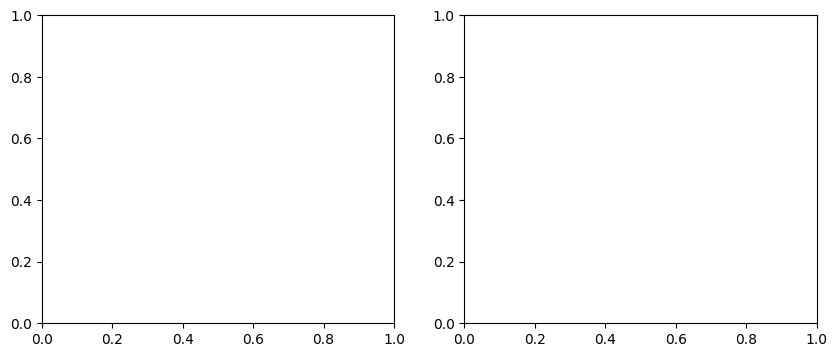

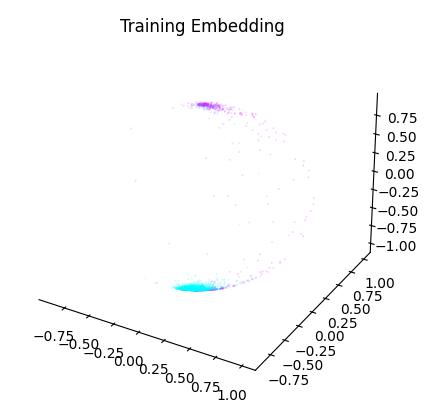

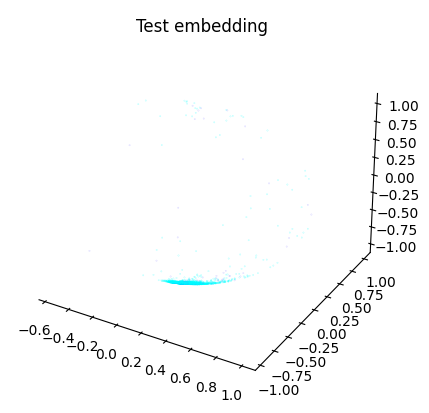

In [6]:
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# trained embedding
embedding = cebra_stim_on_model.transform(neural_training)
cebra.plot_embedding(embedding=embedding, title="Training Embedding", embedding_labels=discrete_training, cmap='cool')

# test embedding
embedding_test = cebra_stim_on_model.transform(neural_test)
cebra.plot_embedding(embedding=embedding_test, title="Test embedding", embedding_labels=discrete_test, cmap='cool')

<Axes: xlabel='Steps', ylabel='Temperature'>

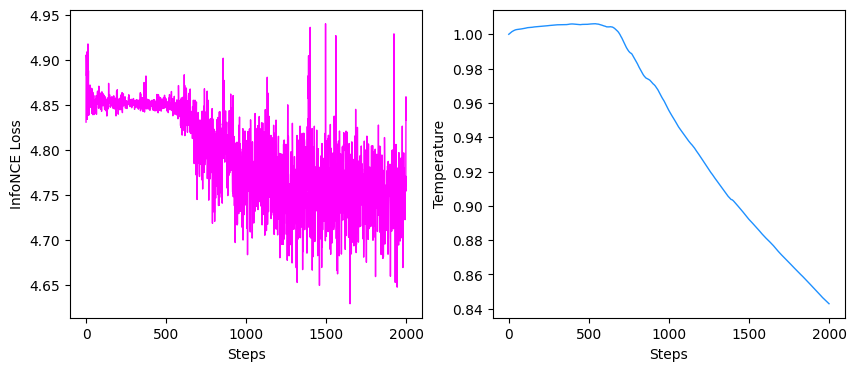

In [7]:
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

cebra.plot_loss(cebra_stim_on_model, ax=ax1)
cebra.plot_temperature(cebra_stim_on_model, ax=ax2)

In [8]:
### Decode ###
decoder = cebra.KNNDecoder()

(embedding_test_train, embedding_test_test,
 discrete_test_train, discrete_test_test) = train_test_split(embedding_test, discrete_test,
                                                             test_size=0.2, shuffle=False)

decoder.fit(embedding_test_train, discrete_test_train)

predictions = decoder.predict(embedding_test_test)

In [ ]:
discrete_test_test[80:120]
predictions[80:120]

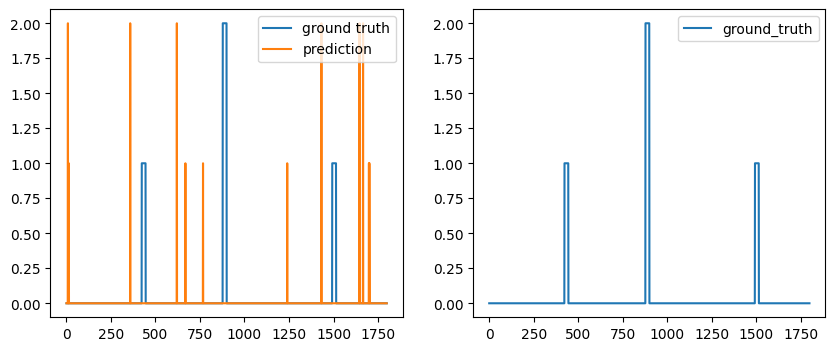

In [9]:
### Visualise ### 
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(discrete_test_test, label='ground truth')
ax1.plot(predictions, label='prediction')
ax1.legend()

ax2.plot(discrete_test_test, label='ground_truth')
ax2.legend()

In [ ]:
embedding_test_test.shape

In [ ]:
# # Decode
decoder_l = cebra.KNNDecoder()
decoder_r = cebra.KNNDecoder()

# split data into train and test
(embedding_train, embedding_test,
 eye_pos_l_train, eye_pos_l_test,
 eye_pos_r_train, eye_pos_r_test)  = train_test_split(embedding, eye_pos_l, eye_pos_r, 
                                                      test_size=0.2, shuffle=False)

# train decoder
decoder_l.fit(embedding_train, eye_pos_l_train)
decoder_r.fit(embedding_train, eye_pos_r_train)

# get score and predictions
score_l = decoder_l.score(embedding_test, eye_pos_l_test)
score_r = decoder_r.score(embedding_test, eye_pos_r_test)

predictions_l = decoder_l.predict(embedding_test)
predictions_r = decoder_r.predict(embedding_test)




In [ ]:
# # plot decoder prediction results 

fig = plt.figure(figsize=(10,8))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))

ax1.set_ylim(-5,30)
ax2.set_ylim(-5,30)
ax3.set_ylim(-30, 5)
ax4.set_ylim(-30, 5)

ax1.plot(eye_pos_l[-3000:-2900], label='eye pos')
ax1.plot(predictions_l[:100], label='predictions')
ax1.legend()

ax2.plot(eye_pos_l[-1000:-500], label='eye pos')
ax2.plot(eye_pos_l[2000:2500], label='predictions')


ax3.plot(eye_pos_r[-3000:-2900], label='eye pos')
ax3.plot(predictions_r[:100], label='predictions'), 


ax4.plot(eye_pos_r[-1000:-500], label='eye pos')
ax4.plot(eye_pos_r[2000:2500], label='predictions')

ax5 = fig.add_subplot(211, frameon=False)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title("Left eye position predictions")

ax5 = fig.add_subplot(212, frameon=False)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title("Right eye position predictions")


In [ ]:
np.where(np.isin(right_spot, 2))
discrete[1555:1590]

In [ ]:
np.where(np.isin(left_spot, 1))
discrete[795:830]

In [ ]:
discrete[700:800]

In [ ]:
stim_on_mask_list[0][793:825]